# 액티브 러닝을 하기 위한 구문
#### 베이스 라인부터 시작해서 학습 후 액티브 러닝, k-mean을 이용하여 추출한 총 300개 정도의 데이터에 수동으로 라벨링한 후 다시 베이스 + 수동 라벨 1.... 학습 + 액티브 러닝 반복하는 식 / 추가로 이미 뽑힌 것은 다시 뽑히지 않도록 방지하는 로직 추가
모델은 TF-IDF + logistic regression을 사용하여 학습하였다.
이를 통해 의미있는 라벨을 가진 데이터를 충분히 모은 뒤 이후 BERT 모델을 사용하여 학습을 진행한다.

In [3]:
# !python baseline_model.py # TF-IDF + logistic regression을 통해 인풋 데이터 comments_labeled + manual_labeled_round*.csv 학습

# import os
# import glob
# import pandas as pd
# from sentiment_utils import select_active_learning_candidates

# CSV_POOL = 'comments_unlabeled.csv'    # 전체 unlabeled 풀
# ART_DIR  = 'artifacts/classic'         # 최신 학습된 모델 디렉토리

# # 1) 지금까지 라벨링된 텍스트 모으기
# labeled_texts = set()

# # base labeled (weak + 이전 merged 등)
# for base_path in ['comments_labeled.csv', 'comments_labeled_merged.csv']:
#     if os.path.exists(base_path):
#         df_base = pd.read_csv(base_path, encoding='utf-8', dtype=str)
#         text_col = 'text' if 'text' in df_base.columns else df_base.columns[0]
#         labeled_texts.update(df_base[text_col].astype(str).tolist())

# # manual_labeled_round*.csv 들 전부 포함
# for p in glob.glob('manual_labeled_round*.csv'):
#     df_m = pd.read_csv(p, encoding='utf-8', dtype=str)
#     text_col = 'text' if 'text' in df_m.columns else df_m.columns[0]
#     labeled_texts.update(df_m[text_col].astype(str).tolist())

# print("지금까지 라벨된 텍스트 개수:", len(labeled_texts))

# # 2) unlabeled 풀에서 이미 본 텍스트 제거
# df_pool = pd.read_csv(CSV_POOL, encoding='utf-8', dtype=str)
# pool_text_col = 'text' if 'text' in df_pool.columns else df_pool.columns[0]
# mask_new = ~df_pool[pool_text_col].astype(str).isin(labeled_texts)
# df_pool_filtered = df_pool[mask_new].reset_index(drop=True)

# print("필터링 전 풀 크기:", len(df_pool))
# print("필터링 후 풀 크기:", len(df_pool_filtered))

# # 필요하면 임시로 저장해두고
# df_pool_filtered.to_csv('comments_unlabeled_filtered.csv', index=False, encoding='utf-8-sig')

# # 3) 필터링된 풀에 대해 Active Learning 후보 뽑기
# df_cand = select_active_learning_candidates(
#     csv_path='comments_unlabeled_filtered.csv',
#     art_dir=ART_DIR,
#     K=65,            # 후보 대략 개수 상한
#     per_cluster=5,   # 클러스터당 몇 개
#     tau_for_low=0.6, # p_max < 0.6 인 애들만
# )

# print("이번 라운드 후보 개수:", len(df_cand))
# df_cand.to_csv('al_round_candidates.csv', index=False, encoding='utf-8-sig')


In [4]:
# from sentiment_utils import batch_predict

# # 이미 artifacts/classic 에 model, vectorizer들이 저장되어 있다고 가정
# batch_predict(
#     csv_path='comments_new.csv',  # 실제 댓글 CSV
#     art_dir='artifacts/classic',
#     out_path='my_new_with_pred.csv',
#     tau=0.42,
#     gap=0.02,
# )

In [5]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # === 1) Load predicted CSV ===
# CSV_PATH = "my_new_with_pred.csv"   # batch_predict에서 out_path로 지정한 파일
# df = pd.read_csv(CSV_PATH, encoding="utf-8")

# # 안전한 text 컬럼 결정
# TEXT_COL = "text_clean" if "text_clean" in df.columns else ("text" if "text" in df.columns else df.columns[0])

# # 클래스 순서 고정
# LABELS = ["neg", "neu", "pos"]



# # === 3) Representative examples per label (top-k by class probability) ===
# def top_examples(ddf: pd.DataFrame, label: str, k: int = 20):
#     pcol = f"p_{label}" if f"p_{label}" in ddf.columns else None
#     sub = ddf[ddf["pred"] == label].copy()
#     if len(sub) == 0:
#         return pd.DataFrame(columns=[TEXT_COL, pcol] if pcol else [TEXT_COL])

#     if pcol:
#         sub = sub.sort_values(pcol, ascending=False)
#         cols = [TEXT_COL, pcol]
#     else:
#         # fallback: 정렬 기준이 없으면 전체 확률 max로 근사
#         prob_cols = [c for c in ddf.columns if c.startswith("p_")]
#         if prob_cols:
#             sub["p_max"] = sub[prob_cols].max(axis=1)
#             sub = sub.sort_values("p_max", ascending=False)
#             cols = [TEXT_COL, "p_max"]
#         else:
#             cols = [TEXT_COL]

#     return sub[cols].head(k)

# label_counts =  df["pred"].value_counts()
# labels = label_counts.index.tolist()
# counts = label_counts.values.tolist()

# plt.figure(figsize=(6, 4))
# plt.bar(labels, counts)
# plt.title("Prediction Label Distribution")
# plt.xlabel("Label")
# plt.ylabel("Count")
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

# for lab in LABELS:
#     print(f"\n===== Top {lab} examples (k=5) =====")
#     disp = top_examples(df, lab, k=30)
#     # 보기 좋게 출력
#     if disp.empty:
#         print("(no examples)")
#     else:
#         for i, row in disp.iterrows():
#             score = None
#             if f"p_{lab}" in disp.columns:
#                 score = row[f"p_{lab}"]
#             elif "p_max" in disp.columns:
#                 score = row["p_max"]
#             text = str(row[TEXT_COL]).strip().replace("\n", " ")
#             if score is not None:
#                 print(f"- [{score:.3f}] {text}")
#             else:
#                 print(f"- {text}")


#주 모델 BERT (학습 데이터가 ./bert_sentiment에 존재할 경우 학습용 데이터를 가지고 마지막 셀만 실행하면됨.)
active learning 이후 정제된 데이터를 얻은 후 pre-trained된 bert모델을 사용하여 라벨이 붙어있는 데이터를 학습시켜 추론을 진행하도록 한다.



# 실행 방법
## 1. 기존 학습된 파일이 없다면 두번 째 셀부터 실행하면 된다.


## 2.https://drive.google.com/file/d/1CSZHLOvhcNfRlcJfelGmcb6PuAeSkJTR/view?usp=drive_link 에서 학습된 파일 bert_sentiment.zip을 다운받아 구글 드라이브 Mydrive에 업로드할 경우 첫번째 셀과 마지막 셀만 실행하면된다.

## 마지막 셀 실행시 comments_for_inference.csv(반응 추론할 댓글 데이터) 필요

In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/bert_sentiment.zip"
extract_dir = "/content"

if os.path.exists(zip_path):
    print(f"[INFO] Found {zip_path}, extracting to {extract_dir} ...")

    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_dir)

    print("[INFO] Unzip done.")

    # 옵션: 제대로 풀렸는지 한번 확인
    bert_dir = os.path.join(extract_dir, "bert_sentiment")
    if os.path.isdir(bert_dir):
        print(f"[INFO] bert_sentiment folder exists at: {bert_dir}")
        print("       Files:", os.listdir(bert_dir))
    else:
        print("[WARN] bert_sentiment folder not found under /content. Check zip structure.")
else:
    print(f"[WARN] {zip_path} not found. Skipping unzip (다음 셀로 그냥 진행해도 됨).")



Mounted at /content/drive
[INFO] Found /content/drive/MyDrive/bert_sentiment.zip, extracting to /content ...
[INFO] Unzip done.
[INFO] bert_sentiment folder exists at: /content/bert_sentiment
       Files: ['sentencepiece.bpe.model', 'special_tokens_map.json', 'config.json', 'tokenizer.json', 'training_args.bin', 'model.safetensors', 'tokenizer_config.json']


## 학습시에만 실행해야함 여기서 Run cell and below(학습이 필요한 경우만)


In [1]:
!pip install -U "transformers[torch]" datasets accelerate
!pip install -q transformers datasets accelerate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 인풋 데이터 경로
FOR_LEARNING_CSV = "comments_labeled_for_training.csv"

df = pd.read_csv(FOR_LEARNING_CSV)

text_col = "text" #댓글 내용
label_col = "label" #댓글 내용에 대한 반응 라벨

label2id = {"neg": 0, "neu": 1, "pos": 2}
id2label = {v: k for k, v in label2id.items()}


df = df[df[label_col].isin(label2id.keys())].copy()
df["label_id"] = df[label_col].map(label2id)

print(df[label_col].value_counts())

train_df, valid_df = train_test_split( #학습용  train, valid비율 나눠서
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"],
)

len(train_df), len(valid_df)


label
neu    9063
pos    5269
neg    3967
Name: count, dtype: int64


(14639, 3660)

In [3]:
from transformers import AutoTokenizer
from datasets import Dataset

model_name = "xlm-roberta-base" #영어, 한국어가 강하게 pre-trained된 bert 모델을 사용

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(examples):
    texts = [str(x) if x is not None else "" for x in examples[text_col]]
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,
    )

# HF Dataset으로 변환
train_ds = Dataset.from_pandas(train_df[[text_col, "label_id"]])
valid_ds = Dataset.from_pandas(valid_df[[text_col, "label_id"]])

# 토크나이징
train_ds = train_ds.map(tokenize_fn, batched=True)
valid_ds = valid_ds.map(tokenize_fn, batched=True)

# label_id → labels
train_ds = train_ds.rename_column("label_id", "labels")
valid_ds = valid_ds.rename_column("label_id", "labels")

# index 컬럼 제거
cols_to_remove = [c for c in train_ds.column_names if c not in ["input_ids", "attention_mask", "labels", text_col]]
train_ds = train_ds.remove_columns([c for c in cols_to_remove if c != text_col])
valid_ds = valid_ds.remove_columns([c for c in cols_to_remove if c != text_col])

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
valid_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/14639 [00:00<?, ? examples/s]

Map:   0%|          | 0/3660 [00:00<?, ? examples/s]

In [4]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": macro_f1}


training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("./bert_sentiment")
tokenizer.save_pretrained("./bert_sentiment")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.046500
100,0.998300
150,0.875100
200,0.824600
250,0.766200
300,0.721600
350,0.765200
400,0.700900
450,0.625100
500,0.647900


('./bert_sentiment/tokenizer_config.json',
 './bert_sentiment/special_tokens_map.json',
 './bert_sentiment/sentencepiece.bpe.model',
 './bert_sentiment/added_tokens.json',
 './bert_sentiment/tokenizer.json')

In [5]:
eval_res = trainer.evaluate()
print(eval_res)

# classification_report
preds = trainer.predict(valid_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

print(classification_report(
    y_true,
    y_pred,
    target_names=["neg", "neu", "pos"],
    digits=4,
))


{'eval_loss': 0.4786008298397064, 'eval_accuracy': 0.8262295081967214, 'eval_macro_f1': 0.8098527354567321, 'eval_runtime': 21.5858, 'eval_samples_per_second': 169.556, 'eval_steps_per_second': 5.328, 'epoch': 3.0}
              precision    recall  f1-score   support

         neg     0.7593    0.6721    0.7130       793
         neu     0.8331    0.8616    0.8471      1813
         pos     0.8578    0.8814    0.8694      1054

    accuracy                         0.8262      3660
   macro avg     0.8167    0.8050    0.8099      3660
weighted avg     0.8242    0.8262    0.8245      3660



The tokenizer you are loading from './bert_sentiment' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The tokenizer you are loading from './bert_sentiment' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Saved → comments_new_with_bert_pred.csv


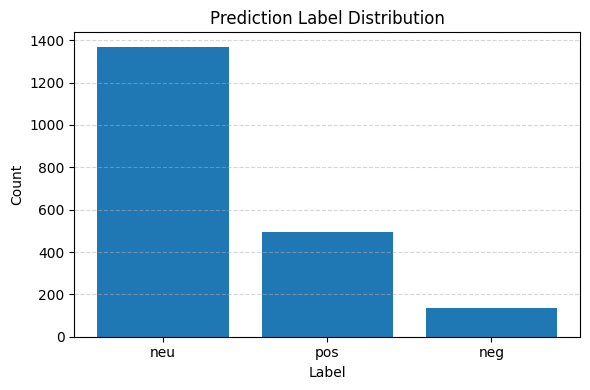


대표 문장 20개 — label: neu
01. *please subscribe and like* 🥹🙏🏻
02. Stick man is that you?
03. how the hell did the guy spin like that on the trampoline?
04. 6:50 bros physics is at 0
05. Legend says he's still laughing...
06. Spin like Jenny wakeman 4:18
07. i found scabers(harry potter fans understand)
08. Hi?
09. ME
10. 1:12  He's not even screaming, he's just purely sounded disgusted
11. 5:05 Meowsturbation
12. 0:17 bro inhaled that burger
13. It’s an old granny playing gta6
14. 5:05 WHATTA HEELLL-
15. 3:20 adam... ADAAAAAAAAAAM...😭
16. bro noooo 😹😹🥄 1:17  Ahaha
17. 2:55
18. I NOT  laghing
19. She got jumpscaer
20. RIP cake😭😭😭😭😭😭😭😭

대표 문장 20개 — label: pos
01. This wasn’t even funny
02. 2:01 THE KITTEN NOOO😢😢😢❤❤
03. Unc nice kitty- *unc throws the kitty* KITTY NOOOOOO
04. 0:17 help  the dog became a minigun😂
05. The world doesnt know what funny means now
06. Cat 😂😂 🐱💀 1:53
07. 1:02 🤣🤣😂 he laughs like a crow that caught me dying
08. ts is not funny
09. kkkkkk muito bom
10. 2:00. He trow 

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

MODEL_DIR = "./bert_sentiment"   # 학습 저장한 폴더
text_col = "text"  # 학습 때 쓰던 컬럼명

# 0) 모델 디렉토리 존재 여부 체크
if not os.path.isdir(MODEL_DIR):
    raise FileNotFoundError(
        f"[ERROR] MODEL_DIR '{MODEL_DIR}' does not exist. "
        "학습된 BERT 모델 폴더 경로를 확인하세요."
    )

# 1) 저장된 tokenizer, model 불러오기 (에러 처리 포함)
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
except Exception as e:
    raise RuntimeError(
        f"[ERROR] Failed to load tokenizer/model from '{MODEL_DIR}'. "
        "해당 폴더에 config.json, pytorch_model.bin, tokenizer 파일들이 있는지 확인하세요."
    ) from e

# 1) 저장된 tokenizer, model 불러오기
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 2) tokenize_fn
def tokenize_fn(examples):
    texts = [str(x) if x is not None else "" for x in examples[text_col]]
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,
    )

# 3) 추론용 데이터셋 만들기
INFERENCE_CSV = "comments_for_inference.csv"

df_new = pd.read_csv(INFERENCE_CSV)
new_texts = df_new[text_col].astype(str).tolist()

new_ds = Dataset.from_dict({text_col: new_texts})
new_ds = new_ds.map(tokenize_fn, batched=True)
new_ds = new_ds.remove_columns(
    [c for c in new_ds.column_names if c not in ["input_ids", "attention_mask", text_col]]
)
new_ds.set_format(type="torch", columns=["input_ids", "attention_mask"])

# 4) 배치 추론
from torch.utils.data import DataLoader
all_logits = []
loader = DataLoader(new_ds, batch_size=32)

with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        all_logits.append(outputs.logits.cpu().numpy())

logits = np.vstack(all_logits)
pred_ids = np.argmax(logits, axis=-1)

id2label = model.config.id2label  # {0:'neg',1:'neu',2:'pos'}
pred_labels = [id2label[int(i)] for i in pred_ids]

df_new["pred_label"] = pred_labels
df_new.to_csv("comments_new_with_bert_pred.csv", index=False, encoding="utf-8-sig")
print("Saved → comments_new_with_bert_pred.csv")


# -----------------------------
# 2) 라벨 비율 그래프 출력
# -----------------------------
label_counts = df_new["pred_label"].value_counts()
labels = label_counts.index.tolist()
counts = label_counts.values.tolist()

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title("Prediction Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# -----------------------------
# 3) 각 라벨별 대표 문장 20개 출력
# -----------------------------
N = 20

for lab in labels:
    print("\n" + "="*80)
    print(f"대표 문장 20개 — label: {lab}")
    print("="*80)

    subset = df_new[df_new["pred_label"] == lab][text_col].head(N)

    for i, sent in enumerate(subset, start=1):
        print(f"{i:02d}. {sent}")
